# Importing LIBS

In [2]:
import numpy
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image
import os

map_base_dir = os.getcwd() + "/train/"
map_img_dir = os.getcwd() + '/train/images/'

from pycocotools import mask as cocomask
from pycocotools.coco import COCO
from skimage.morphology import binary_erosion, rectangle, binary_dilation
from scipy.ndimage.morphology import distance_transform_edt

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Data Loading and prep

### Load

In [4]:
json_path = os.path.join(map_base_dir, 'annotation.json')
coco = COCO(json_path)
image_ids = coco.getImgIds()

loading annotations into memory...
Done (t=34.21s)
creating index...
index created!


### prepare

In [38]:
def get_mask_from_image_id(image_id,new_size):
    image = coco.loadImgs(image_id)[0]
    image_size = (image["height"], image["width"])

    mask_overlayed = np.zeros(image_size).astype('uint8')

    annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=[100, ])
    annotations = coco.loadAnns(annotation_ids)
    mask = np.zeros(image_size)
    for ann in annotations:
        rle = cocomask.frPyObjects(ann['segmentation'], image_size[0], image_size[1])
        m = cocomask.decode(rle)

        for i in range(m.shape[-1]):
            mi = m[:, :, i]
            mi = mi.reshape(image_size)
            mask += mi
    numpy_image = np.where(mask > 0, 1, 0).astype('uint8')
    PIL_image = Image.fromarray(numpy_image.astype('uint8'), 'L')
    
    img = PIL_image.resize( (new_size,new_size) )
    img_array = np.array(img)
    result = np.zeros( (new_size, new_size, 2) )
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            result[i][j][img_array[i][j]] = 1
    return np.asarray(result)

In [39]:
def get_original_from_id(image_id,new_size):
    n = image_id
    i = 1
    while n > 10:
        n = n / 10
        i = i + 1
    name = (12 - i)* "0" + str(image_id) + ".jpg"
    img = Image.open( os.path.join(map_img_dir, name) )
    img = img.resize((new_size,new_size))
    img_array = np.array(img)
    return np.asarray(img_array)

In [7]:
def create_mask_viz(prediction):
    result = np.zeros( (prediction.shape[:2]))
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            result[i][j] = np.argmax(prediction[i][j])
    return result

### Data visualization

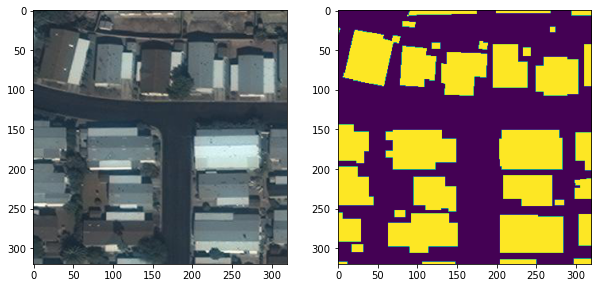

In [40]:
fig, m_axs = plt.subplots(1,2, figsize = (10, 5))
sample_id = 240405
img = get_original_from_id(sample_id,320)
x = get_mask_from_image_id(sample_id,320)
x = create_mask_viz(x)
m_axs[0].imshow(img)
m_axs[1].imshow(x)

In [12]:
x.shape

(320, 320)

### image generator

In [41]:
class sat_im_gen(keras.utils.Sequence):

    def __init__(self, image_ids, img_size, batch_size):
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_ids = image_ids

    def __len__(self):
        return len(self.image_ids) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_ids = self.image_ids[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, image_id in enumerate(batch_image_ids):
            img = get_original_from_id(image_id,img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (2,), dtype="uint8")
        
        for j, image_id in enumerate(batch_image_ids):
            img = get_mask_from_image_id(image_id,img_size)
            y[j] = img#(np.expand_dims(img, 3)/255).round().astype(int)
        return x, y

#### getting rid of bad image files

In [14]:
image_ids = [ int(x.split(".")[0]) for x in os.listdir(os.getcwd()+"/train/images") if x.split(".")[-1] == "jpg"]
len(image_ids)

280741

In [15]:
for imid in image_ids:
    try:
        original = get_original_from_id(imid)
    except :
        image_ids.remove(imid)
len(image_ids)

280736

#### Train Val Test split 

In [16]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(image_ids, test_size = 0.4)
val_ids, test_ids = train_test_split(test_ids, test_size = 0.5)

In [17]:
print( len(train_ids) ) 
print( len(val_ids) )
print( len(test_ids) )

168441
56147
56148


#### create gen instants

In [18]:
BATCH_SIZE = 16


test_gen = sat_im_gen(
    test_ids, 
    (320,320),
    BATCH_SIZE
)

val_gen = sat_im_gen(
    val_ids, 
    (320,320),
    BATCH_SIZE
)

train_gen = sat_im_gen(
    train_ids, 
    (320,320),
    BATCH_SIZE
)

# Model Arch and training

we will try and compare the results of 2 architectures the first is U-net and the second is based on ViT. we will compare Accuracy for train, validation and test. The goal here is to segment the satelite images to buildings and background.

## Unet model and results

In [17]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [18]:
def downsample_block(x, n_filters, padding = "same"):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2, padding = padding)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [19]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)

    return x

In [20]:
def build_unet_model():
    
    inputs = layers.Input(shape=(320,320,3))
    f1, p1 = downsample_block(inputs, 32)
    f2, p2 = downsample_block(p1, 64)
    f3, p3 = downsample_block(p2, 64)
    f4, p4 = downsample_block(p3, 128)

    bottleneck = double_conv_block(p4, 256)
    
    u6 = upsample_block(bottleneck, f4, 128)
    u7 = upsample_block(u6, f3, 64)
    u8 = upsample_block(u7, f2, 64)
    u9 = upsample_block(u8, f1, 32)

    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net-sat")

    return unet_model

In [21]:
sat_unet_model = build_unet_model()
sat_unet_model.summary()

2023-09-29 15:00:42.081019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-29 15:00:42.088345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-29 15:00:42.088468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "U-Net-sat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 320, 320, 32  9248        ['conv2d[0][0]']                 
                                )                                                         

In [ ]:
optimizer=tf.keras.optimizers.Adam()
sat_unet_model.compile(optimizer=optimizer,
                   loss="categorical_crossentropy",
                   metrics="categorical_accuracy")
NUM_EPOCHS = 4
callbacks = [
    keras.callbacks.ModelCheckpoint("sat_building_segmentation.h5", save_best_only=True)
]

model_history = sat_unet_model.fit(
    train_gen,
    epochs=NUM_EPOCHS,
    validation_data=val_gen,
    verbose=1,
    callbacks=callbacks)

Epoch 1/4


2023-09-29 15:01:02.569282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-29 15:01:04.308343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net-sat/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-29 15:01:05.750558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-29 15:01:08.506053: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x26821f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-29 15:01:08.506075: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device 

9777/9777 [==============================] - ETA: 0s - loss: 0.2539 - categorical_accuracy: 0.9021

2023-09-29 16:44:26.923193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9777/9777 [==============================] - 8251s 843ms/step - loss: 0.2539 - categorical_accuracy: 0.9021 - val_loss: 0.1445 - val_categorical_accuracy: 0.9440
Epoch 2/4
9777/9777 [==============================] - 8323s 851ms/step - loss: 0.1485 - categorical_accuracy: 0.9420 - val_loss: 0.1369 - val_categorical_accuracy: 0.9468
Epoch 3/4
9777/9777 [==============================] - 8232s 842ms/step - loss: 0.1356 - categorical_accuracy: 0.9472 - val_loss: 0.1315 - val_categorical_accuracy: 0.9505
Epoch 4/4
9777/9777 [==============================] - ETA: 0s - loss: 0.1296 - categorical_accuracy: 0.9497

## Results

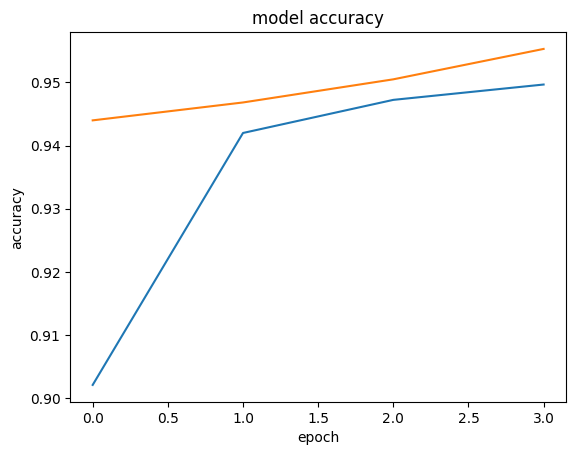

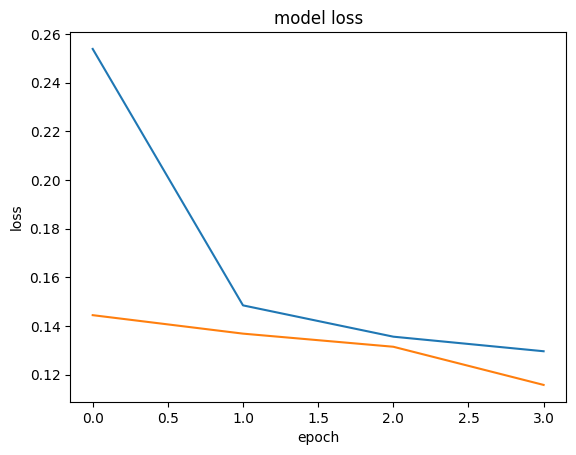

In [23]:
history = model_history
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [25]:
score = sat_unet_model.evaluate(test_gen, verbose=0)
print("model Accurac y: {0:.2%}".format(score[1]))

2023-09-30 11:03:02.407141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


model Accurac y: 95.52%


In [26]:
sample_test_gen = sat_im_gen(
    test_ids[:4], 
    (320,320),
    4
)

In [27]:
predictions = sat_unet_model.predict(sample_test_gen)

2023-09-30 11:41:32.958841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 1s/step


In [28]:
def plot_tri_im(original, target, prediction):
    fig = plt.figure(figsize=(15, 10))
    fig.add_subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("origianl")
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(target,cmap='gray')
    plt.title("target segmentation")
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(prediction,cmap='gray')
    plt.title("prediction segmentation")
    plt.axis('off')

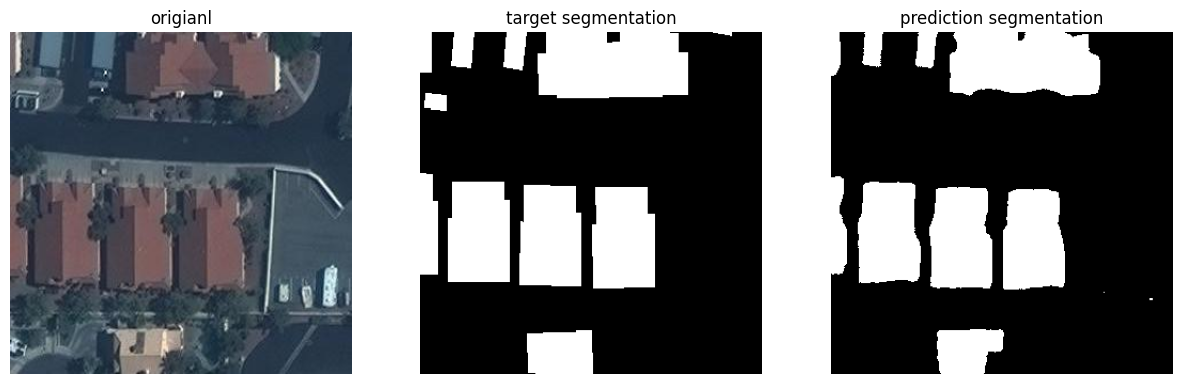

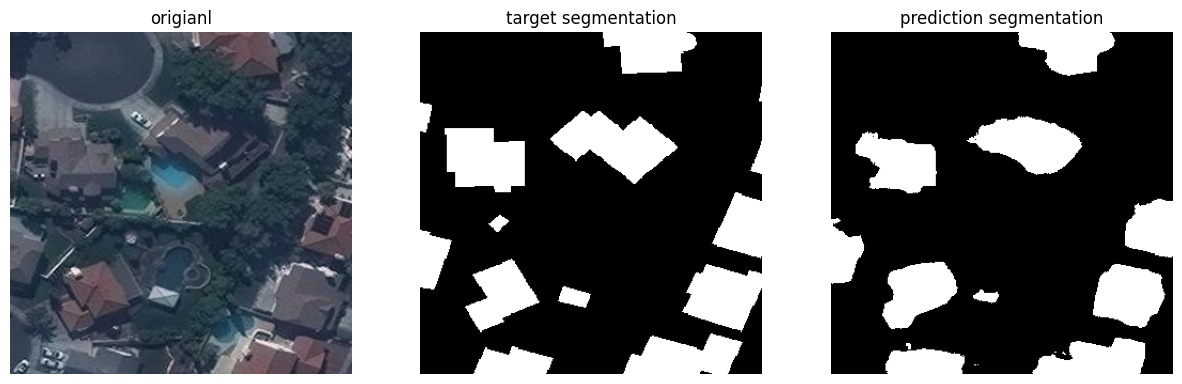

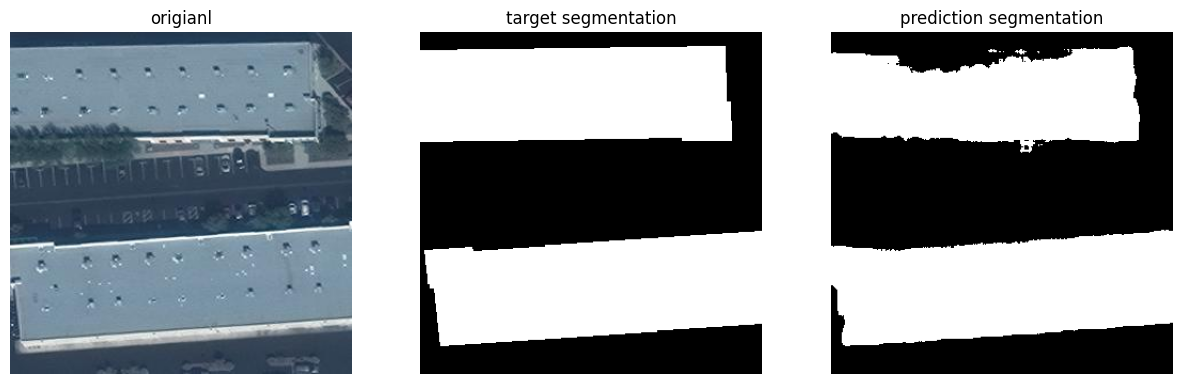

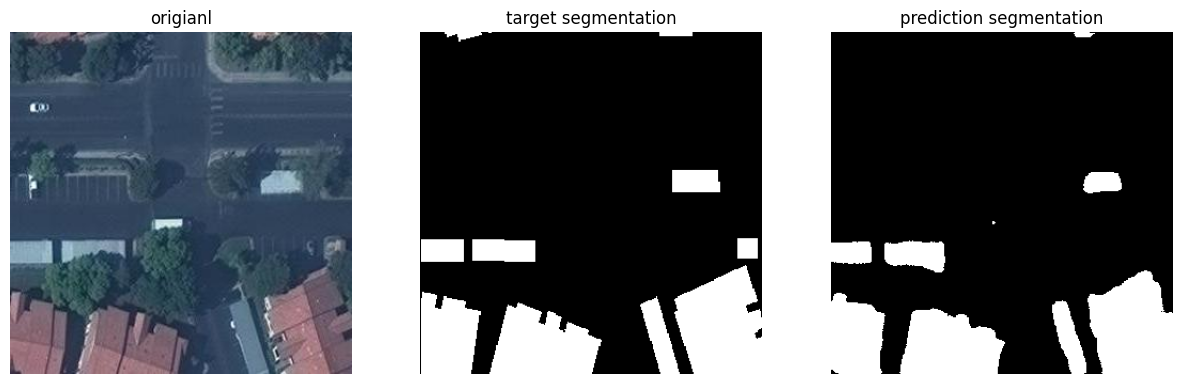

In [29]:
sample_test_ids = test_ids[:4]
for prediction , sample_test_id in zip(predictions,sample_test_ids):
    original = get_original_from_id(sample_test_id)
    target = get_mask_from_image_id(sample_test_id)
    target = create_mask_viz(target)
    result = np.zeros( (prediction.shape[:2]))
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            result[i][j] = np.argmax(prediction[i][j])
    plot_tri_im(original, target, result)